클러스터링을 통하여 필터링된 adata에 대하여 고찰해보자

## 1. Environment Set Up
## 1.1 Library upload

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import igraph as ig
import scanpy as sc
import scanpy.external as sce
from scipy.sparse import csr_matrix, isspmatrix
import gseapy as gp

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Custom functions
sys.path.append('../HelperFunctions')
import Helper as fn

In [2]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, fontsize=12)

## 2. Read input files

In [3]:
id = 'Id0003'
input_file = f'../data/{id}/Day1_2_TrevinoFiltNormAdata.h5ad'
adata = sc.read(input_file)

In [4]:
### adata 확인
print('Loaded Normalizes AnnData object: number of cells', adata.n_obs)
print('Loaded Normalizes AnnData object: number of genes', adata.n_vars)

print('Available metadata for each cell: ', adata.obs.columns)

Loaded Normalizes AnnData object: number of cells 45888
Loaded Normalizes AnnData object: number of genes 16324
Available metadata for each cell:  Index(['Auth_Sample.ID', 'Auth_Age', 'Auth_Tissue.ID', 'Auth_Sample.Type',
       'Auth_Assay', 'Auth_Batch', 'Auth_seurat_clusters', 'Auth_RNA.Counts',
       'Auth_RNA.Features', 'Auth_Percent.MT', 'Auth_Percent.Ribo',
       'Auth_Cell.Barcode', 'Auth_DF_pANN', 'Auth_DF_classification',
       'Auth_DF_pANN_quantile', 'Auth_Spliced.Counts', 'Auth_Spliced.Features',
       'Auth_Unspliced.Counts', 'Auth_Unspliced.Features',
       'Auth_Ambiguous.Counts', 'Auth_Ambiguous.Features', 'dataset_id',
       'sample_id', 'brain_region', 'age', 'stage', 'batch_key', 'cell_label',
       'cell_class', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'total_counts_mito',
       'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo',
       'log1p_total_counts_ribo', 'pct_counts_ribo', 'gene_UMI

## 3. Cluster characteristics
## 3.1 Check with original annotation

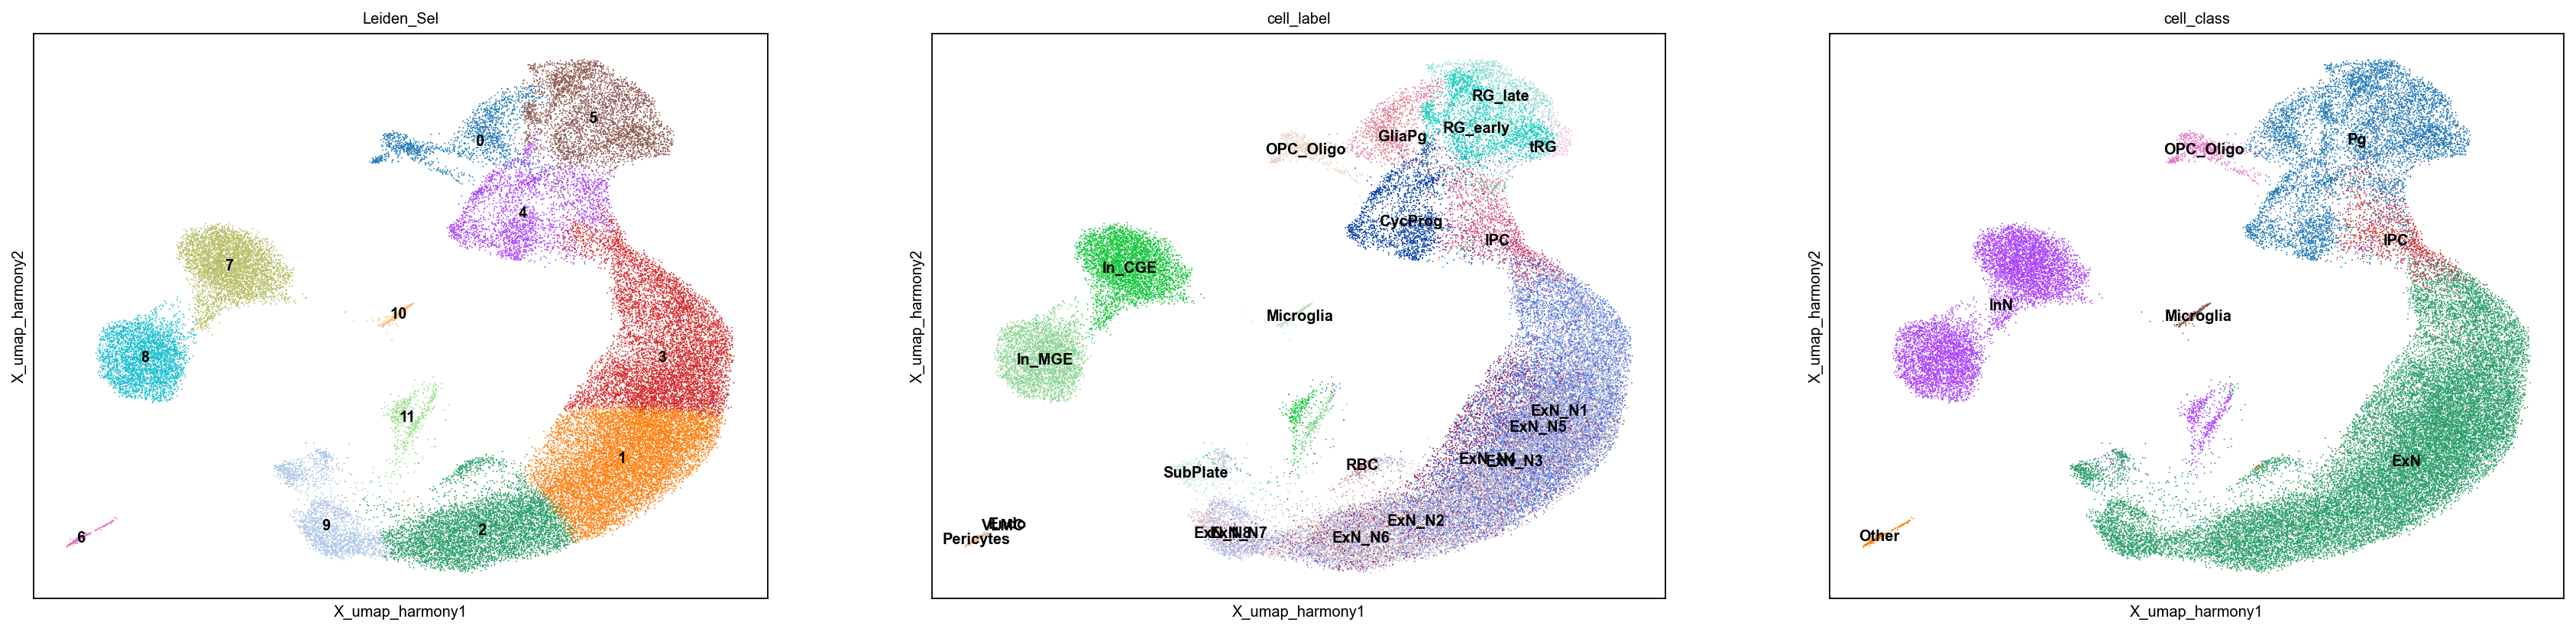

In [5]:
sc.settings.set_figure_params(fontsize=9, figsize=[8, 6])
sc.pl.embedding(
    adata,
    basis="X_umap_harmony",
    color=['Leiden_Sel', 'cell_label', 'cell_class'],
    legend_loc='on data'
    )

In [6]:
### 각 세포 클래스 별로 어느 Leiden 클러스터에 속하는지 확인
pd.crosstab(
    adata.obs['cell_class'],
    adata.obs['Leiden_Sel'],
    normalize = 'columns', # 각 열 별로 비율을 계산한다
    margins=True
    )

Leiden_Sel         0         1         2         3         4         5    6  \
cell_class                                                                    
Pg          0.637890  0.001237  0.001399  0.016032  0.863368  0.994245  0.0   
Other       0.000000  0.000972  0.002177  0.001179  0.000369  0.000240  1.0   
ExN         0.000000  0.991962  0.993780  0.888129  0.002216  0.000719  0.0   
IPC         0.001799  0.000530  0.000000  0.092184  0.128877  0.004077  0.0   
InN         0.000000  0.001590  0.000622  0.000707  0.003323  0.000000  0.0   
Microglia   0.000000  0.003445  0.001710  0.001532  0.000369  0.000480  0.0   
OPC_Oligo   0.360312  0.000265  0.000311  0.000236  0.001477  0.000240  0.0   

Leiden_Sel         7         8         9   10        11       All  
cell_class                                                         
Pg          0.000231  0.000573  0.003526  0.0  0.001859  0.168214  
Other       0.000693  0.000287  0.000881  0.0  0.000000  0.006450  
ExN         0.000462  0.001147  0.978845  0.0  0.109665  0.598196  
IPC         0.000693  0.000287  0.000000  0.0  0.007435  0.025388  
InN         0.995146  0.995986  0.015866  0.0  0.881041  0.181442  
Microglia   0.002543  0.001720  0.000881  1.0  0.000000  0.006930  
OPC_Oligo   0.000231  0.000000  0.000000  0.0  0.000000  0.013380

In [7]:
### _Try yourself_: what if you want to see total number of cells instead of %?
### 만약 각 열 별로 비율이 아니라 개수를 보고 싶다면?
pd.crosstab(
    adata.obs['cell_class'],
    adata.obs['Leiden_Sel'],
    margins=True
)

Leiden_Sel     0      1     2     3     4     5    6     7     8     9   10  \
cell_class                                                                    
Pg          1064     14     9   136  2338  4146    0     1     2     8    0   
Other          0     11    14    10     1     1  253     3     1     2    0   
ExN            0  11230  6391  7534     6     3    0     2     4  2221    0   
IPC            3      6     0   782   349    17    0     3     1     0    0   
InN            0     18     4     6     9     0    0  4305  3474    36    0   
Microglia      0     39    11    13     1     2    0    11     6     2  233   
OPC_Oligo    601      3     2     2     4     1    0     1     0     0    0   
All         1668  11321  6431  8483  2708  4170  253  4326  3488  2269  233   

Leiden_Sel   11    All  
cell_class              
Pg            1   7719  
Other         0    296  
ExN          59  27450  
IPC           4   1165  
InN         474   8326  
Microglia     0    318  
OPC_Oligo     0    614  
All         538  45888

In [8]:
### _Try yourself_: what if you want to compare with the more granular annotation?
### 만약 좀 더 세분화된 그룹으로 보고 싶다면?
pd.crosstab(
    adata.obs['cell_label'], # 세포 종류별로 그룹화 이전의 원래 컬럼을 쓴다
    adata.obs['Leiden_Sel'],
    normalize='columns',
    margins=True
)

Leiden_Sel         0         1         2         3         4         5  \
cell_label                                                               
CycProg     0.009592  0.000000  0.000000  0.008605  0.717873  0.014149   
Endo        0.000000  0.000795  0.000155  0.000472  0.000000  0.000240   
ExN_N1      0.000000  0.199364  0.016638  0.273135  0.000000  0.000000   
ExN_N2      0.000000  0.106881  0.381589  0.000354  0.000000  0.000000   
ExN_N3      0.000000  0.021553  0.024413  0.006012  0.000000  0.000000   
ExN_N4      0.000000  0.173571  0.168559  0.088884  0.000000  0.000000   
ExN_N5      0.000000  0.484763  0.139170  0.518920  0.002216  0.000000   
ExN_N6      0.000000  0.002827  0.224226  0.000000  0.000000  0.000000   
ExN_N7      0.000000  0.001855  0.034365  0.000354  0.000000  0.000240   
ExN_N8      0.000000  0.000088  0.002954  0.000000  0.000000  0.000000   
GliaPg      0.617506  0.000000  0.000000  0.003183  0.079025  0.039568   
IPC         0.001799  0.000530  0.000000  0.092184  0.128877  0.004077   
In_CGE      0.000000  0.000972  0.000311  0.000354  0.003323  0.000000   
In_MGE      0.000000  0.000618  0.000311  0.000354  0.000000  0.000000   
Microglia   0.000000  0.003445  0.001710  0.001532  0.000369  0.000480   
OPC_Oligo   0.360312  0.000265  0.000311  0.000236  0.001477  0.000240   
Pericytes   0.000000  0.000000  0.000000  0.000354  0.000000  0.000000   
RBC         0.000000  0.000177  0.002021  0.000354  0.000369  0.000000   
RG_early    0.007194  0.001237  0.001399  0.001532  0.037297  0.516067   
RG_late     0.002998  0.000000  0.000000  0.000000  0.004431  0.340048   
SubPlate    0.000000  0.001060  0.001866  0.000472  0.000000  0.000480   
VLMC        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
tRG         0.000600  0.000000  0.000000  0.002711  0.024742  0.084412   

Leiden_Sel         6         7         8         9   10        11       All  
cell_label                                                                   
CycProg     0.000000  0.000000  0.000287  0.000000  0.0  0.000000  0.045611  
Endo        0.225296  0.000231  0.000000  0.000441  0.0  0.000000  0.001613  
ExN_N1      0.000000  0.000231  0.000000  0.000000  0.0  0.016729  0.102227  
ExN_N2      0.000000  0.000000  0.000287  0.014103  0.0  0.009294  0.080740  
ExN_N3      0.000000  0.000000  0.000000  0.000881  0.0  0.000000  0.009894  
ExN_N4      0.000000  0.000000  0.000000  0.033936  0.0  0.007435  0.084641  
ExN_N5      0.000000  0.000000  0.000000  0.003085  0.0  0.031599  0.235683  
ExN_N6      0.000000  0.000000  0.000000  0.036139  0.0  0.014870  0.034083  
ExN_N7      0.000000  0.000231  0.000573  0.472014  0.0  0.024164  0.029049  
ExN_N8      0.000000  0.000000  0.000000  0.194799  0.0  0.005576  0.010133  
GliaPg      0.000000  0.000231  0.000000  0.000000  0.0  0.000000  0.031315  
IPC         0.000000  0.000693  0.000287  0.000000  0.0  0.007435  0.025388  
In_CGE      0.000000  0.990291  0.015195  0.010137  0.0  0.479554  0.101181  
In_MGE      0.000000  0.004854  0.980791  0.005729  0.0  0.401487  0.080261  
Microglia   0.000000  0.002543  0.001720  0.000881  1.0  0.000000  0.006930  
OPC_Oligo   0.000000  0.000231  0.000000  0.000000  0.0  0.000000  0.013380  
Pericytes   0.758893  0.000231  0.000287  0.000441  0.0  0.000000  0.004315  
RBC         0.000000  0.000231  0.000000  0.000000  0.0  0.000000  0.000436  
RG_early    0.000000  0.000000  0.000287  0.003085  0.0  0.001859  0.050340  
RG_late     0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.031272  
SubPlate    0.000000  0.000000  0.000287  0.223887  0.0  0.000000  0.011746  
VLMC        0.015810  0.000000  0.000000  0.000000  0.0  0.000000  0.000087  
tRG         0.000000  0.000000  0.000000  0.000441  0.0  0.000000  0.009676

### 위의 도표를 통해 어떤 것을 알 수 있는가?
* Leiden 클러스터링 결과, 각 클러스터에서 한 가지 종류의 클래스가 비중이 많다.
* 따라서 이 클러스터링을 통하여 어느 세포 클래스가 어느 클러스터에서 가장 비율이 많은지 알 수 있다
    * Excitatory Neurons: C2, C3 (IPC), C4, C9
    * Inhibitory Neurons: C6, C8, C11
    * Progenitors: C1, C7
    * Glia: C0 (progenitors, OPC), C10 (microglia)
    * Other: C5

### 3.2 Cluster dendrogram
* Dendrogram은 hierarchial clustering 결과를 시각화한다
* 어떤 데이터 포인트/그룹이 얼마나 유사한지(가까운지) 한눈에 파악할 수 있다

    using 'X_pca' with n_pcs = 5
Storing dendrogram info using `.uns['dendrogram_Leiden_Sel']`


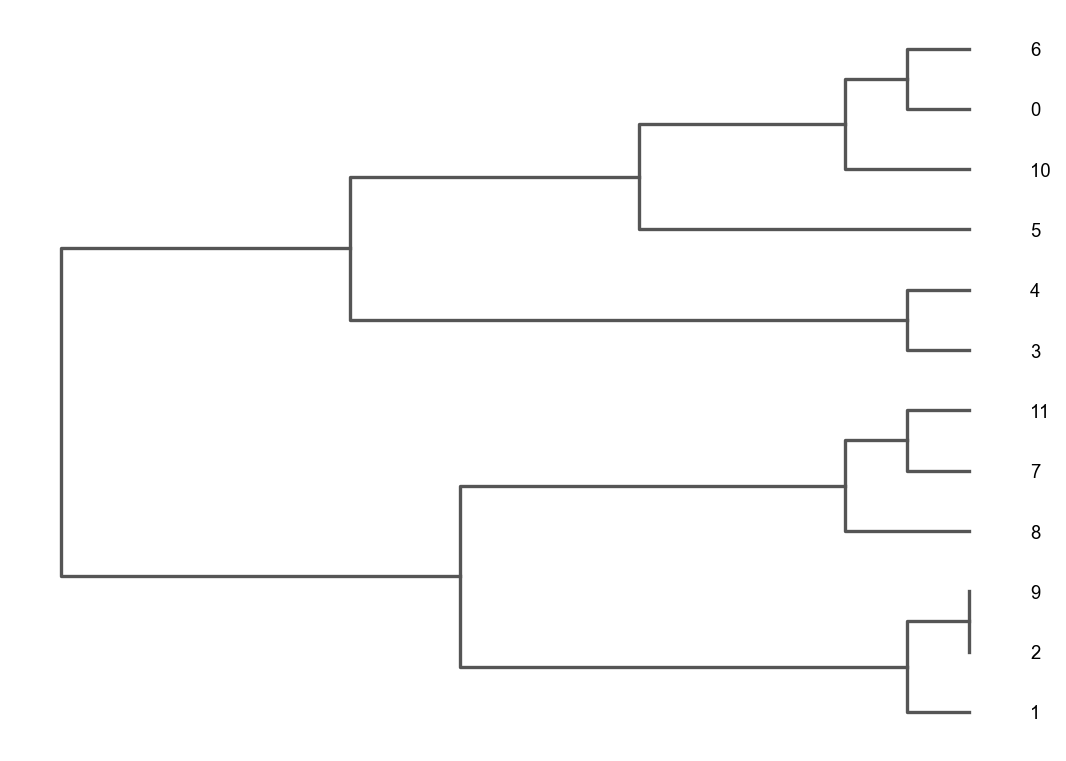

<Axes: >

In [9]:
sc.settings.set_figure_params(fontsize=10, figsize=[8, 6])

sc.tl.dendrogram( # dendrogram 생성을 위한 tl(tool) 정의
    adata, # 데이터
    groupby='Leiden_Sel', # dendrogram 기준 클러스터 컬럼
    n_pcs=5, # PCA 결과의 처음 5개의 PC를 사용
    cor_method='spearman', # 그룹 간 유사도 계산 알고리즘은 '스피어만' 상관계수법
    linkage_method='average' # 그룹 간 거리 계산 알고리즘은 '평균연결' 방식
    )

sc.pl.dendrogram( # dendrogram 생성 (plot)
    adata,
    groupby='Leiden_Sel',
    orientation='left' # dendrogram 그려지는 방향 (default는 윗쪽)
    )

    using 'X_pca' with n_pcs = 5
Storing dendrogram info using `.uns['dendrogram_Auth_seurat_clusters']`


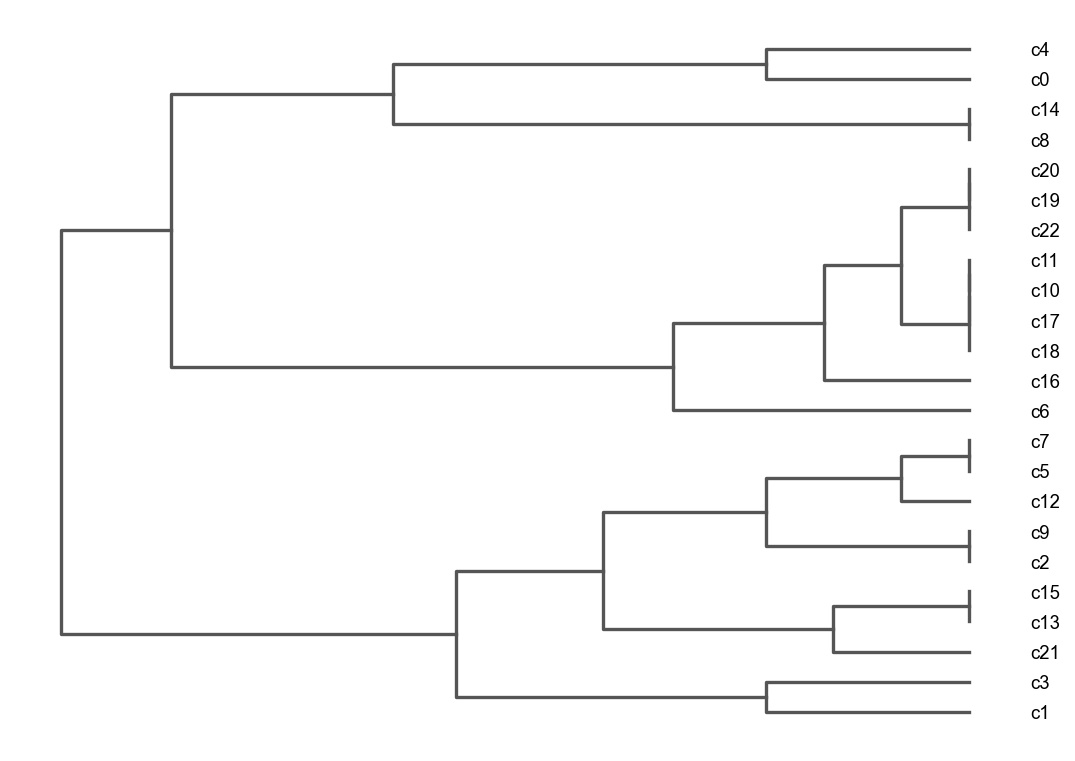

<Axes: >

In [10]:
###  _Try yourself_: How to compare to a dendrogram created on the annotation from the original paper?
###  만약 데이터 출처 논문(original paper)의 dendrogram과 비교하고 싶다면?
sc.tl.dendrogram(
    adata,
    groupby='Auth_seurat_clusters', # Leiden clustering 대신 논문의 seurat clustering을 사용
    n_pcs=5,
    cor_method='spearman',
    linkage_method='average'
)

sc.pl.dendrogram(
    adata,
    groupby='Auth_seurat_clusters',
    orientation='left'
)

## 4. Population markers
* 지도접근(Supervised approach): UMAP 위에 사용자가 설정한 세포군집(population) 마커를 그려본다(plot)
    * 세포군집 마커는 생물학적 배경(biological knowledge), 참고문헌(literature survey), 연구맥락(conext)에 따라서 달라진다.
    * **이 실험에서는 마커를 dictionary 형태로 제공한다**
    * `Helper.py`의 `customUmap` 함수를 이용할 것이다.
    * 스스로 함수를 생성해서 시도해도 된다.

In [11]:
marker_dictionary = {

    'Proliferating_Progenitors': ['MKI67', 'CDC20', 'HMGB2', 'CCNB1', 'CCNB2', 'ASPM'], 
    'Radial_Glia': ['SOX2', 'PAX6', 'NES', 'VIM', 'HES1', 'GLI3'],
    'Intermediate_Progenitors': ['EOMES', 'ELAVL4', 'NHLH1', 'KCNQ3', 'INSM1', 'HES6'], 
    'oRG': ['FAM107A', 'HOPX',  'PTPRZ1', 'TNC', 'ITGB5'], 
    
    'Neurons': ['GAP43', 'DCX', 'STMN2', 'MAP2', 'SYT1', 'MEF2C'], 
    
    'Excitatory_Progenitors': ['EMX1', 'NEUROD1', 'NEUROD2', 'NEUROD6', 'NEUROG2', 'NEUROG1'],
    'Excitatory_Neurons': ['SLC17A6', 'SLC17A7', 'GRIN2A', 'GRIN2B', 'SLA'], 
    
    'Inhibitory_Early': ['NKX2-1', 'DLX5', 'DLX6', 'DLX1', 'DLX2', 'DLX6-AS1'],
    'Inhibitory_Neurons': ['GAD1', 'GAD2', 'SLC32A1', 'CALB1', 'CALB2', 'NPY', 'SST', 'PVALB', 'VIP'],
    
    'Astrocytes': ['GFAP', 'SLC1A3',  'S100B', 'AQP4', 'ALDH1L1', 'TNC'], 
    'Microglia': ['PTPRC', 'AIF1', 'CCL3', 'ITGAM', 'CX3CR1', 'CD74'], 
    
    'Endothelial_Pericytes': ['CLDN5', 'PECAM1', 'ABCG2', 'FOXC2', 'PDGFRB', 'IFITM2'], 
    }

In [32]:
sc.settings.set_figure_params(dpi=80, fontsize=12)

### 아래의 코드를 실행하면 12개의 그래프가 생성된다
'''
for population in marker_dictionary: 
    print(f"{population.upper()}:")
    fn.customUmap(adata, marker_dictionary[population], size=8)
    print("\n\n\n")
'''

'\nfor population in marker_dictionary: \n    print(f"{population.upper()}:")\n    fn.customUmap(adata, marker_dictionary[population], size=8)\n    print("\n\n\n")\n'

RANDOM_TOP_GENES:

The following marker genes are missing:  set()


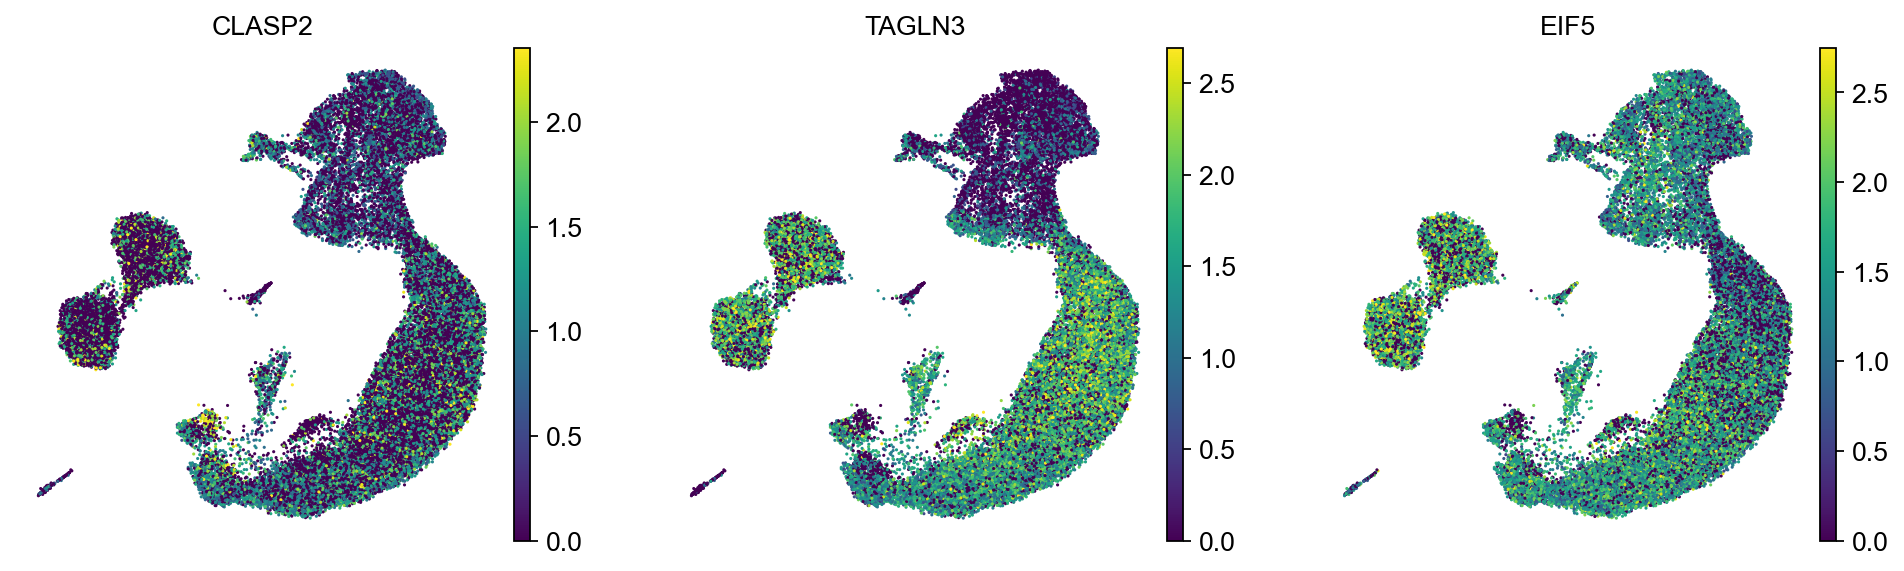





RANDOM_BOTTOM_GENES:

The following marker genes are missing:  set()


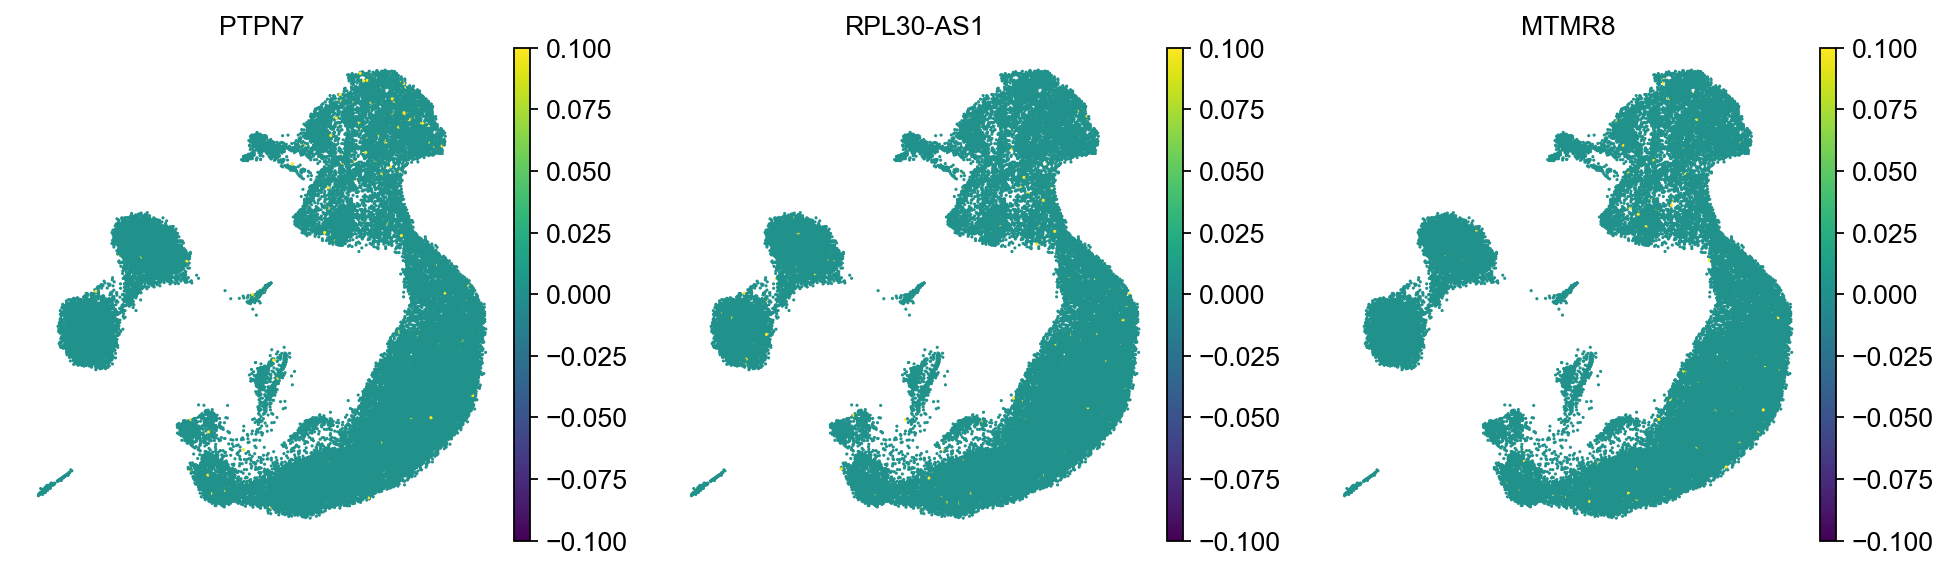

In [21]:
### _Try yourself_: define below a small dictionary of genes you are interested in and plot them on the UMAP
### 세포군집 마커를 직접 정의해보고, UMAP 위에 표시해보자

### 전체 유전자 카운트 수가 상위 10%와 하위 10%에 해당하는 유전자를 그려보자
sorted_genes = adata.var['total_counts'].sort_values(ascending=False)
top = np.percentile(sorted_genes, 90)
bottom = np.percentile(sorted_genes, 10)

top_genes = sorted_genes[sorted_genes >= top].index
bottom_genes = sorted_genes[sorted_genes <= bottom].index

my_marker_dictionary = {
    "random_top_genes": np.random.choice(top_genes, 3, replace=False),
    "random_bottom_genes": np.random.choice(bottom_genes, 3, replace=False)
}

for population in my_marker_dictionary: 
    print(f"{population.upper()}:")
    fn.customUmap(adata, my_marker_dictionary[population], size=8)
    print("\n\n\n")

## 5. Cluster Top Markers
## 5.1 Identifyu Cluster top-markers
* 각 클러스터마다 top-marker = 각 클러스터 내에서 발현량이 높은 유전자들
* Scanpy의 `tl.rank_genes_groups' 함수를 사용


In [ ]:
adata.uns['log1p']['base'] = None # 로그화된 데이터에서 'base' 컬럼값을 none으로

### 발현량 높은 유전자 조사하기
sc.tl.rank_genes_groups(
    adata,
    groupby='Leiden_Sel', # 클러스터 그룹 선택
    method='wilcoxon', # 유전자 발현량 비교 알고리즘 선택
    key_added='wilcox', # 분석 결과는 adata.uns에 저장되는데, adata.uns['wilcox']에 저장
    use_raw=False, # adata.raw 사용 여부
    pts=True # 각 유전자가 클러스터 내에서 발현하는 비율도 퍼센테지로 함께 계산
    )

ranking genes
    finished: added to `.uns['wilcox']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:33)


In [ ]:
### 조사한 유전자 목록을 pandas dataframe으로 불러오기
GroupMarkers = pd.DataFrame(adata.uns['wilcox']['names']).head(101)
GroupMarkers.columns = 'Cl_' + GroupMarkers.columns

GroupMarkers.head(11)

Cl_0     Cl_1     Cl_2      Cl_3    Cl_4     Cl_5      Cl_6      Cl_7  \
0       BCAN     ENC1    SATB2   TMEM158   HMGN2      VIM    IGFBP7  DLX6-AS1   
1        DBI    GRIA2    STMN2      HES6   HMGB2    TTYH1    IFITM3      BTG1   
2      OLIG1      SLA   LIMCH1     SSTR2   HMGB1      PTN     GNG11   CCDC88A   
3     PTPRZ1   POU3F2    GPM6A      NRN1    SMC4    FABP5     SPARC      DLX5   
4      OLIG2    MEIS2      SLA     PRDX1   CENPF   SLC1A3       FN1     ERBB4   
5      METRN  NEUROD2  NEUROD2  MIR99AHG  TUBA1B      ID4       B2M      DLX1   
6      CSPG5     NRP1     SYT4      LRP8   TOP2A      CLU    MYL12A      DLX2   
7     PDGFRA    GPM6A   TUBA1A      SOX4   H2AZ1    SFRP1  ARHGAP29     NR2F2   
8        QKI      CPE   ADRA2A     DDAH2  NUSAP1    GPM6B    COL4A1      TCF4   
9      GPM6B   SEMA3C     DAB1   PPP1R17    H2AX  ZFP36L1    COL4A2      MEG3   
10  MIR9-1HG    PALMD   PLXNA4      NFIA   MKI67    PEA15      JUNB     PCDH9   

        Cl_8     Cl_9    Cl_10     Cl_11  
0      ERBB4    MEF2C      FTL  DLX6-AS1  
1        MAF    NELL2     SPP1     ERBB4  
2   DLX6-AS1   GRIN2B     AIF1      DLX5  
3    PDE4DIP   ARPP21   TYROBP      DLX2  
4        ARX    CALM1      B2M       DCX  
5       DLX2    MAP1B    RGS10       ARX  
6        DCX     CHL1    ITM2B   PDE4DIP  
7      CXCR4    CELF2  S100A11      PLS3  
8   C11orf96    GAP43     SAT1      DLX1  
9       PLS3  SLITRK5     CTSB   CCDC88A  
10      RBP1   TUBB2A     TPT1    SLAIN1

## 5.2 Visualize marker genes

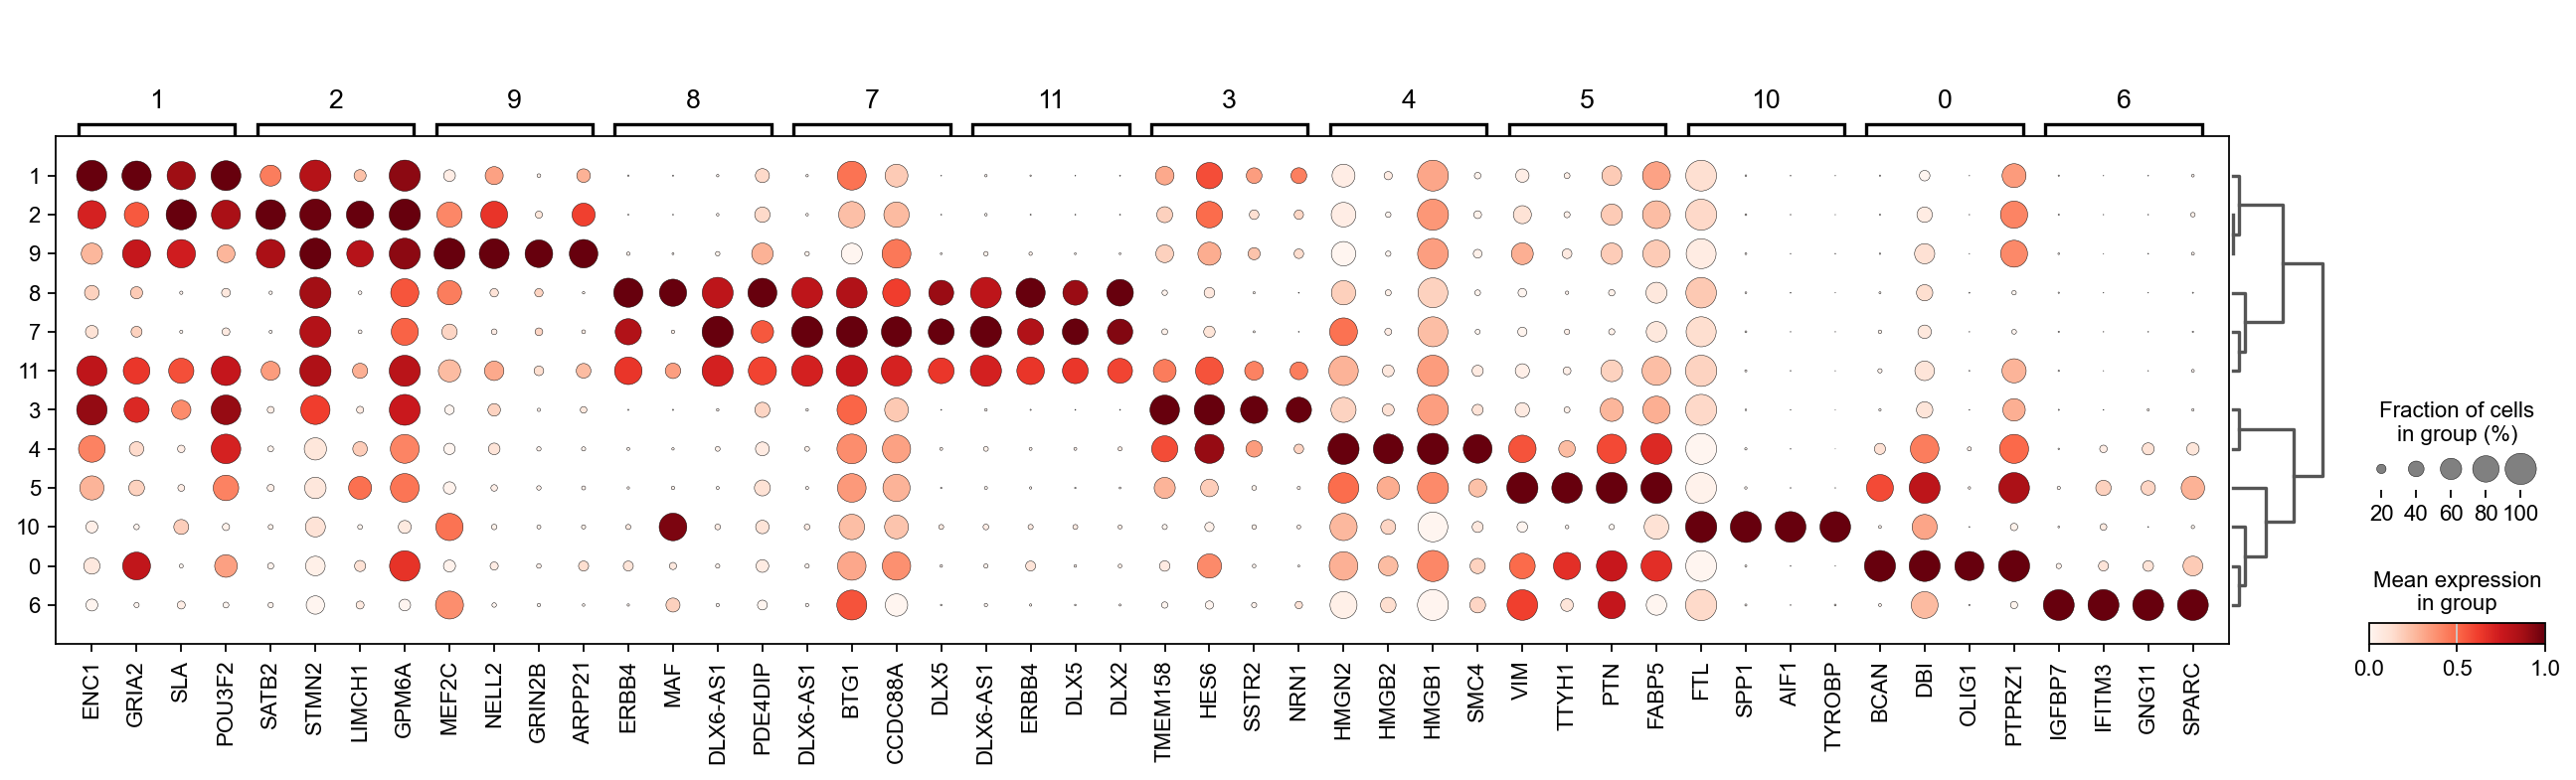

In [ ]:
### DotPlot 그려보기
### 점의 크기 = 클러스터 내에서 유전자가 발현하는 세포비율
### 점의 색깔 = 평균 발현량
sc.pl.rank_genes_groups_dotplot(
    adata,
    n_genes=4, # 각 클러스터에서 상위 유전자 4개만 출력
    key='wilcox', # adata.uns['wilcox']에서 불러오기
    standard_scale="var" # 각 유전자 발현량 스케일링 방법. 'var'은 각 클러스터 별로 0에서 1까지 정규화
    )  

## 5.3 Filter top marker genes
* `tl.rank_genes_groups' 함수를 사용해 생성한 top-marker 결과에 필터링을 해보자
    * 다른 클러스터 내에서의 발현비율과 비교해서 상위 마커를 필터링

In [25]:
sc.tl.filter_rank_genes_groups(
    adata,
    min_in_group_fraction=0.3, # 타겟으로 하는 클러스터 내에서 발현 비율이 30% 이상
    max_out_group_fraction=0.2, # 다른 클러스터 내에서 발현 비율이 20% 이하
    key="wilcox", # adata.uns['wilcox']에서 불러오기
    key_added="wilcox_filt", # adata.uns['wilcox_filt']에 저장히기
)

Filtering genes using: min_in_group_fraction: 0.3 min_fold_change: 1, max_out_group_fraction: 0.2


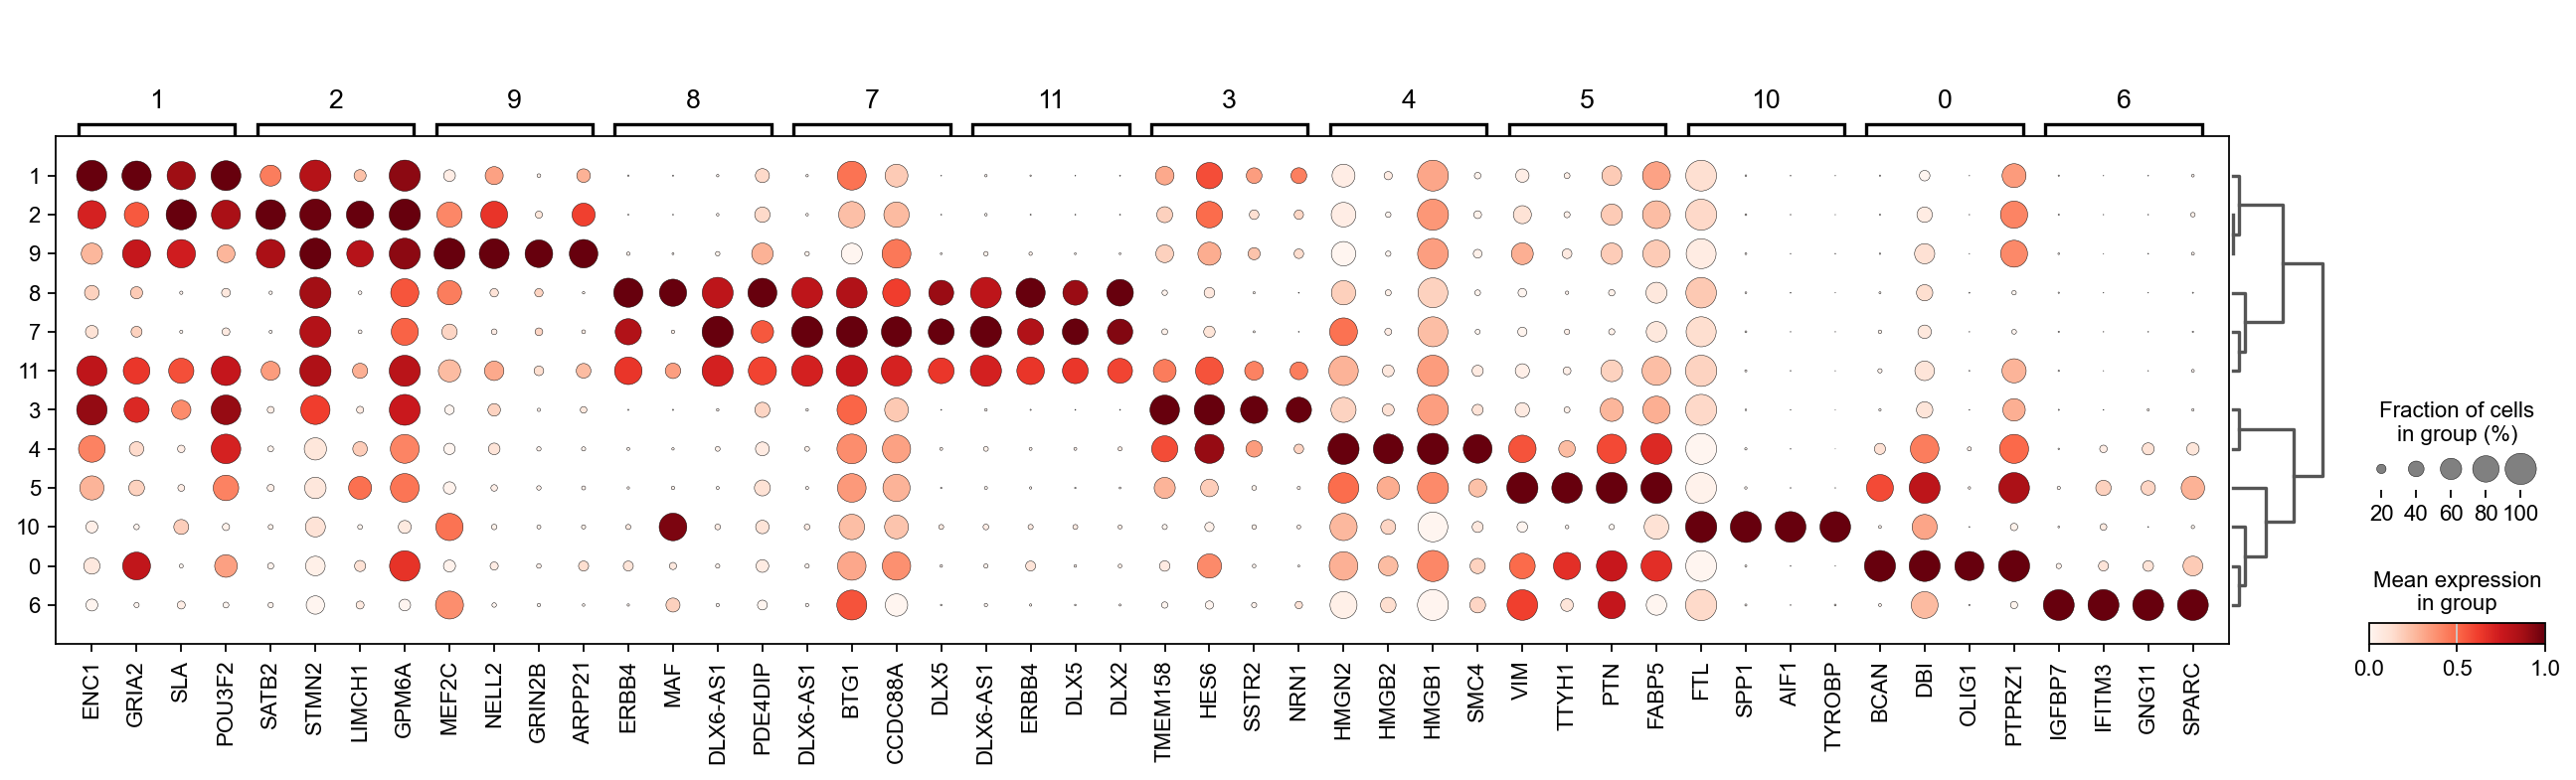

In [26]:
### 동일한 방식으로 DotPlot 그려보기
sc.pl.rank_genes_groups_dotplot(
    adata,
    n_genes=4,
    key='wilcox', 
    standard_scale="var"
    )

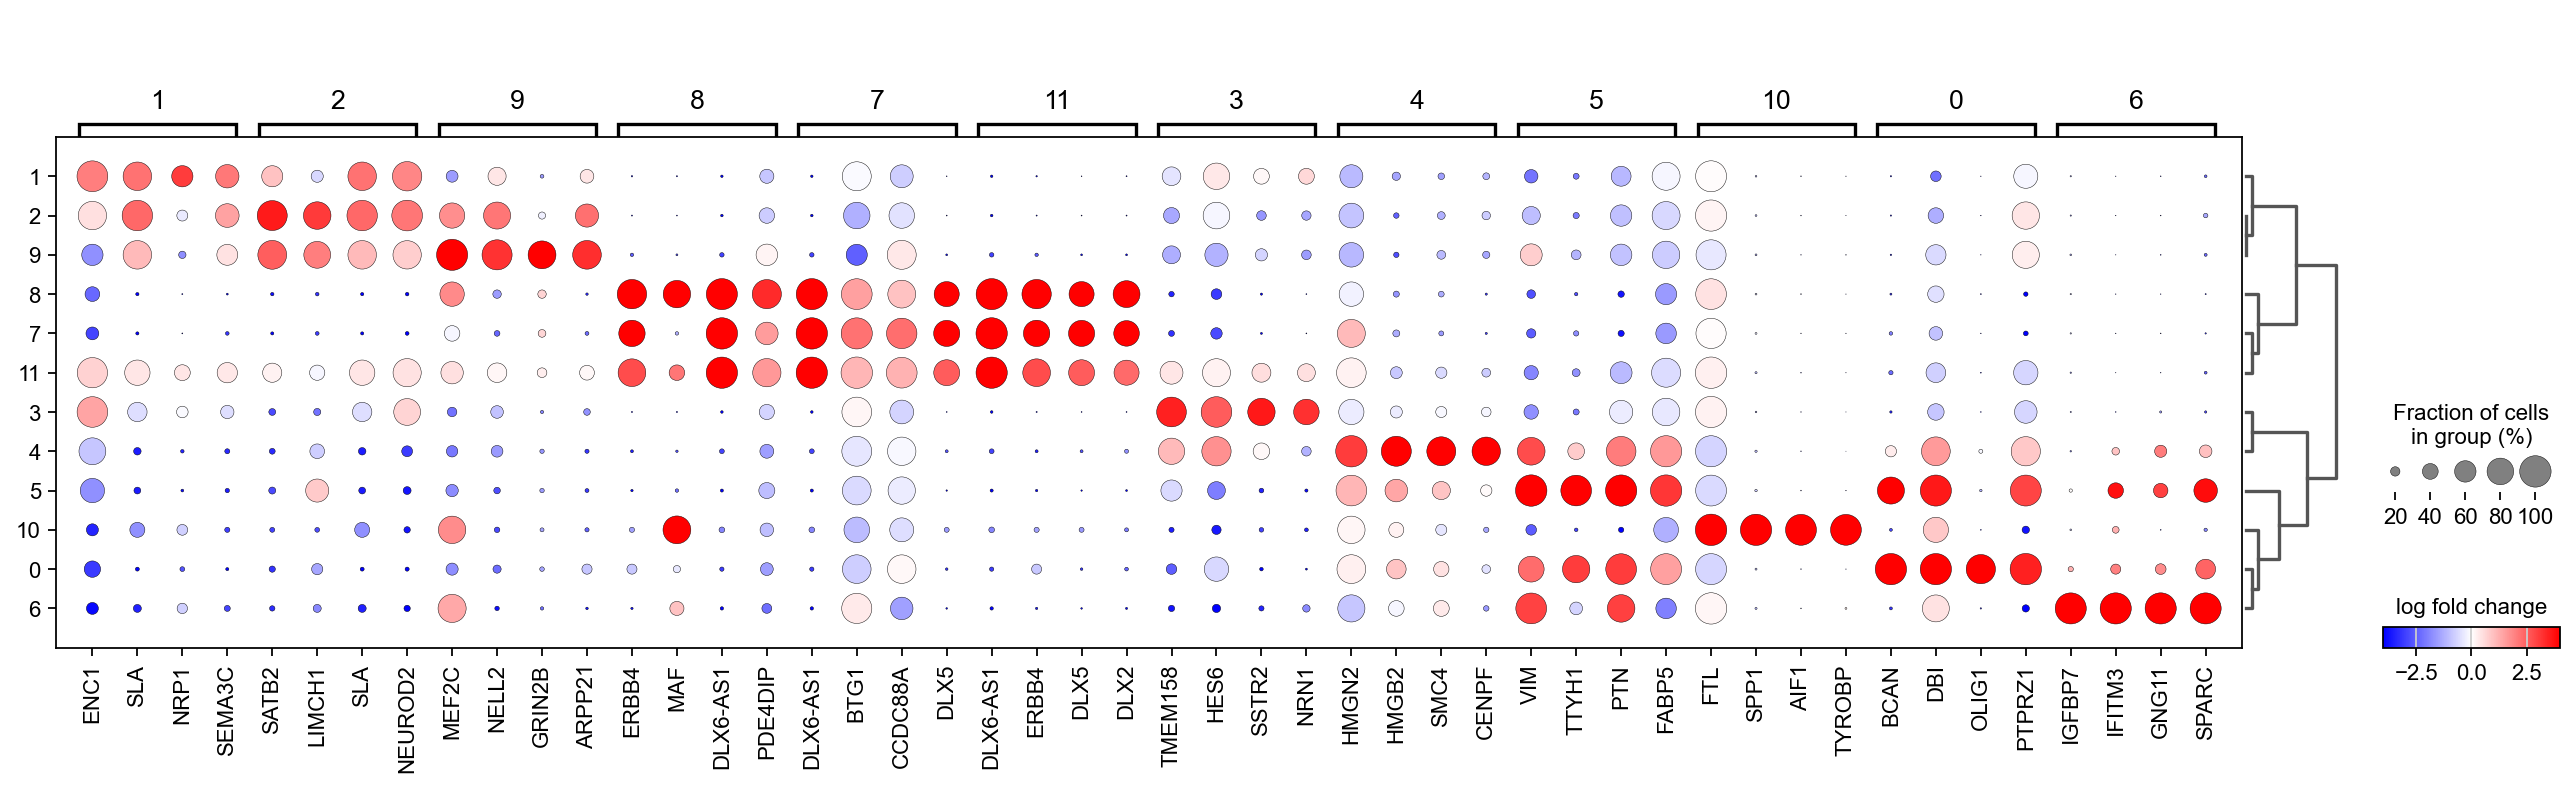

In [ ]:
### DotPlot 새로 그려보기
sc.pl.rank_genes_groups_dotplot(
    adata,
    key='wilcox',
    n_genes=4, # 클러스터 내 상위 4개 유전자
    values_to_plot="logfoldchanges", # 각 점의 색깔을 결정할 값을 'logfoldchanges' 사용
    cmap='bwr', # 팔레트 변경
    vmin=-4, # 색상 그라데이션 최소값
    vmax=4, # 색상 그라데이션 최댓값
    min_logfoldchange=2, # log fold change값의 최소값을 지정
    colorbar_title='log fold change',
)

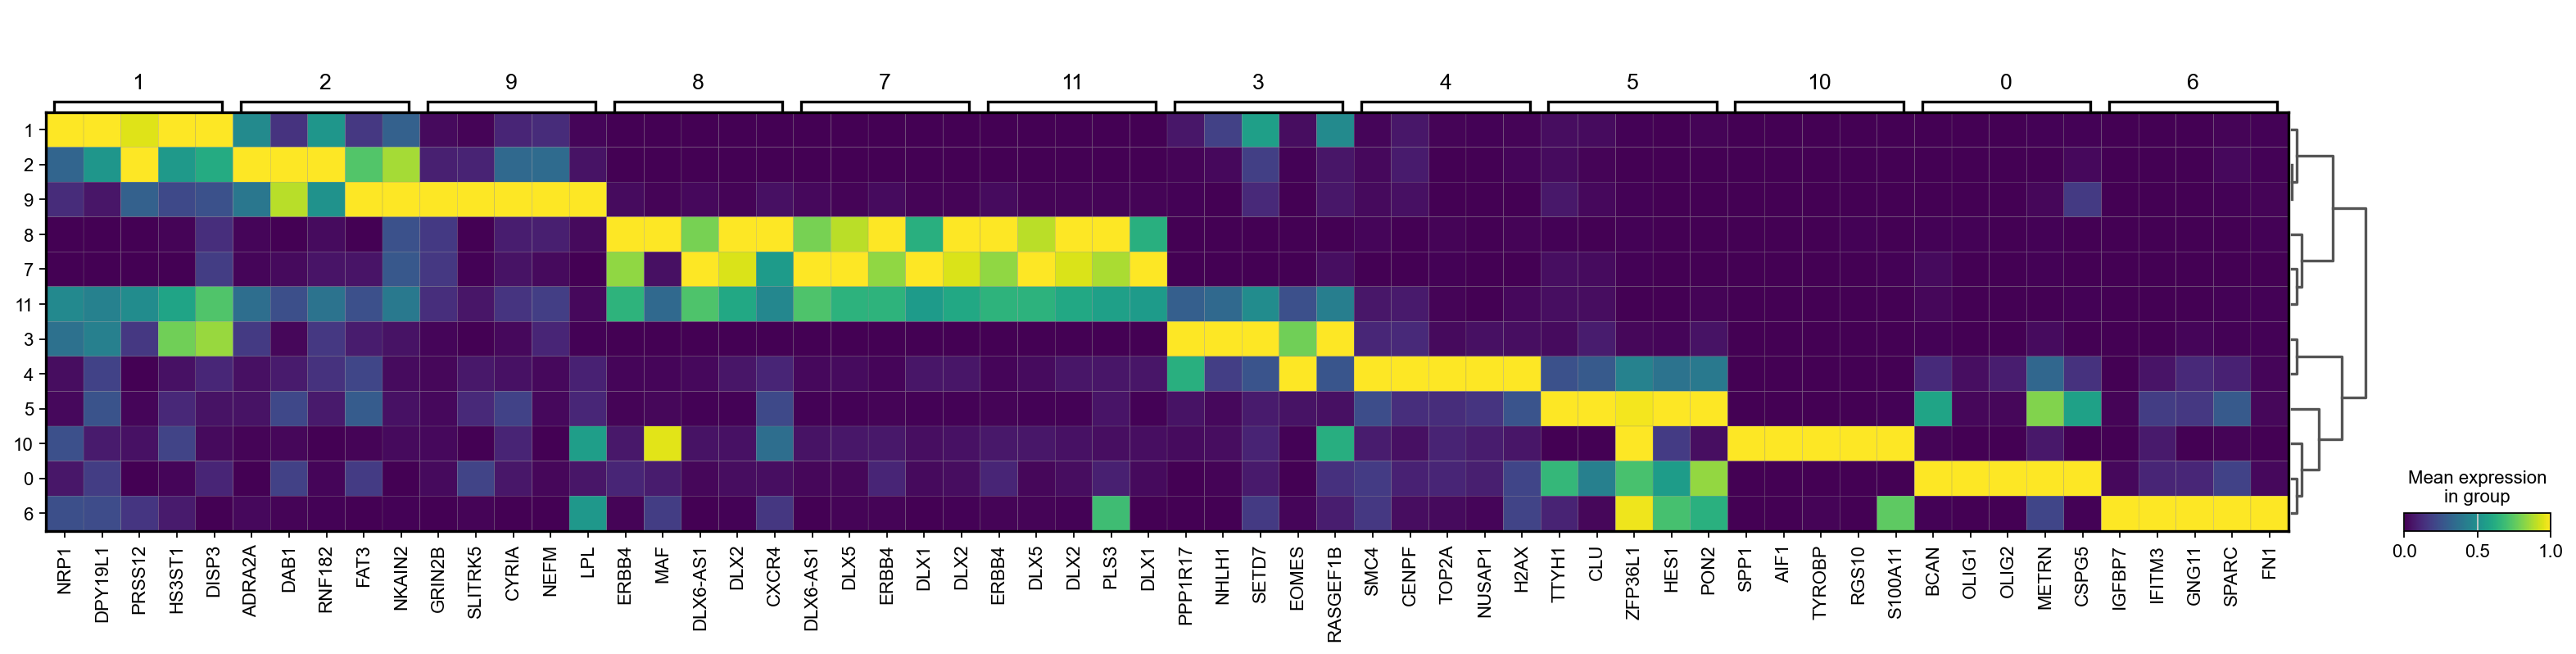

In [28]:
### matrixplot 그리기
sc.pl.rank_genes_groups_matrixplot(
    adata,
    n_genes=5, # 상위 5개 유전자
    key='wilcox_filt', #adata.uns['wilfox_filt']에서 불러오기
    standard_scale="var"  #  각 클러스터마다 발현량을 정규화
    )

## 5.4 Marker overlap
* 각 클러스터의 상위 발현량을 가진 유전자 리스트와 사용자 정의의 유전자 리스트를 비교해보자
* 두 리스트의 오버래핑하는 정도를 비교해볼 수 있다

In [ ]:
marker_overlap = sc.tl.marker_gene_overlap(
    adata,
    marker_dictionary, # 이 유전자 목록은 상단에서 정의된 '마커' 리스트이다
    key='wilcox', #adata.uns['wilfox']에서 불러오기
    top_n_markers=100, # 각 클러스터 별로 상위 100개의 유전자 선택해서
    method='jaccard' # 두 유전자 리스트의 오버래핑을 비교할 방법으로 'Jaccard index' 사용
    )

marker_overlap.columns = marker_overlap.columns.astype('category') # 저장

<Axes: >

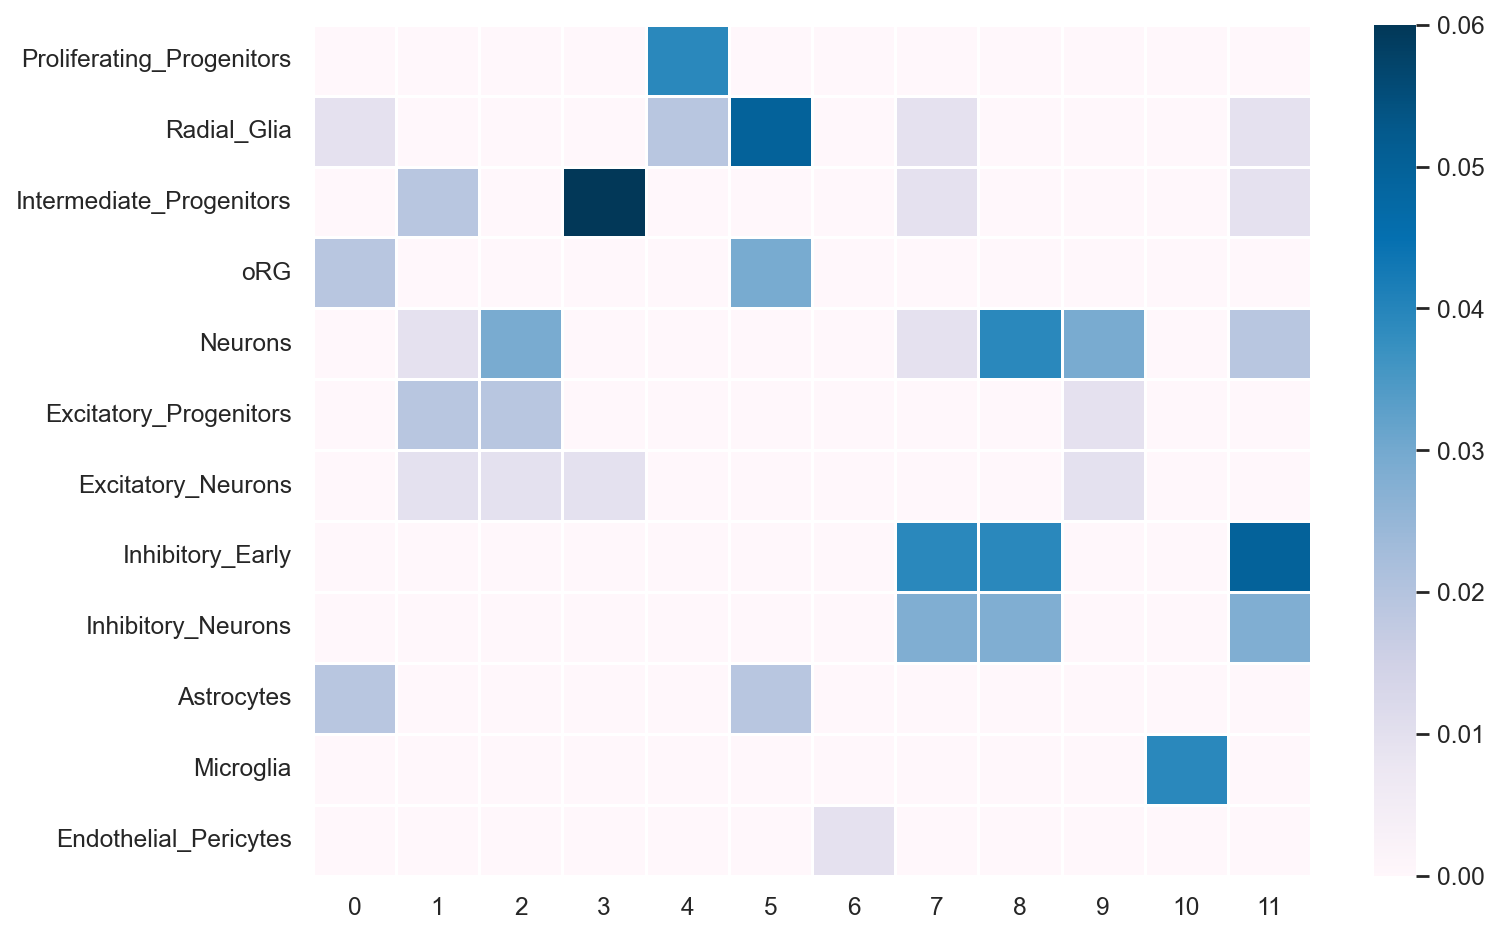

In [ ]:
sns.set_theme()
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(marker_overlap,
            linewidths=.5,
            ax=ax,
            cmap = 'PuBu'
            )

## 6. Functional analysis by gseapy
## 6.1 Approaches
* gseapy를 이용한 분석 방법에는 두 가지가 있다
    1. over-representation analysis(ORA)
        * 기능적으로 관련된 유전자 세트가 관심있는 유전자 세트 내에 얼마나 있는지 전체 유전사 세트와 비교하는 분석
    2. gsea-like apporaches
        * p-value, fold-change 같은 통계값들을 이용해 유전자들의 순위를 매긴 후, 특정 유전자 세트가 이 순위목록의 상위에 있는지 혹은 전체에 고르게 분포하는지 확인한다

In [31]:
# to check available gene sets
gp.get_library_name()[:5]

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues']

## 6.2 Pre-ranked GSEA
* `Helper.py`의 `customGseapy` 함수는 다음의 과정을 거친다
    1) scanpy가 계산한 점수를 기준으로 pre-ranked 목록을 생성하고 순위를 생성
    2) pre-ranked 목록에 원하는 유전자 세트들을 대상으로 GSEA(Gene Set Enrichment Analysis) 수행

In [33]:
### 클러스터 목록
### C1: progenitors
### C8: inhibitory neurons
### C9: excitatory neurons
### C10: microglia 
Cl = ['1', '8' , '9', '10']

### 각 클러스터 별로 수행
for i in Cl: 
    print("\n\n {}".format(i)) 
    display(fn.customGseapy(adata, cluster=i, rank='wilcox', 
                            sets = ['GO_Biological_Process_2023'],
                            fdr_th=0.005, nes_th=1.75, show=5))



2025-08-10 21:58:23,197 [WARNING] Duplicated values found in preranked stats: 0.07% of genes
The order of those genes will be arbitrary, which may produce unexpected results.




 1


Empty DataFrame
Columns: [nes, pval, fdr, fwerp, tag %, gene %, lead_genes]
Index: []

2025-08-10 21:58:40,117 [WARNING] Duplicated values found in preranked stats: 0.50% of genes
The order of those genes will be arbitrary, which may produce unexpected results.




 8


nes pval       fdr  \
GO_Biological_Process_2023__Negative Regulation...  2.074918  0.0  0.004248   

                                                    fwerp tag % gene %  \
GO_Biological_Process_2023__Negative Regulation...  0.005  6/22  4.26%   

                                                                               lead_genes  
GO_Biological_Process_2023__Negative Regulation...  PFN2;TMSB10;TMSB4X;HIP1R;SSH2;TMSB15A

2025-08-10 21:58:44,351 [WARNING] Duplicated values found in preranked stats: 0.22% of genes
The order of those genes will be arbitrary, which may produce unexpected results.




 9


nes pval       fdr  \
GO_Biological_Process_2023__Positive Regulation...  1.763633  0.0   0.00414   
GO_Biological_Process_2023__Regulation Of Heart...  1.759533  0.0   0.00414   
GO_Biological_Process_2023__Negative Regulation...  1.757055  0.0  0.003312   
GO_Biological_Process_2023__Regulation Of Monoa...  1.755721  0.0   0.00276   
GO_Biological_Process_2023__Synaptic Vesicle Re...  1.751929  0.0  0.002366   

                                                    fwerp  tag %  gene %  \
GO_Biological_Process_2023__Positive Regulation...  0.005  37/69  16.99%   
GO_Biological_Process_2023__Regulation Of Heart...   0.01  19/47  10.89%   
GO_Biological_Process_2023__Negative Regulation...   0.01   6/20   3.46%   
GO_Biological_Process_2023__Regulation Of Monoa...   0.01  28/59  15.54%   
GO_Biological_Process_2023__Synaptic Vesicle Re...   0.01  27/42  16.93%   

                                                                                           lead_genes  
GO_Biological_Process_2023__Positive Regulation...  GRIN2B;VAMP2;SYT1;CACNG8;TSHZ3;NPTN;PRKCZ;PLK2...  
GO_Biological_Process_2023__Regulation Of Heart...  CALM1;CELF2;ATP2B1;SLC8A1;ANK2;CALM3;ATP2B2;RY...  
GO_Biological_Process_2023__Negative Regulation...           STMN1;PIK3R1;TMEFF2;CLASP1;DYNLL1;CLASP2  
GO_Biological_Process_2023__Regulation Of Monoa...  MEF2C;SCN3B;YWHAH;FGF12;ANK2;CACNG8;SHISA9;MAP...  
GO_Biological_Process_2023__Synaptic Vesicle Re...  DNM3;SNCA;VAMP2;RAB3A;AP3S1;SYT5;SYT1;AP2B1;DN...

2025-08-10 21:58:48,725 [WARNING] Duplicated values found in preranked stats: 7.74% of genes
The order of those genes will be arbitrary, which may produce unexpected results.




 10


nes pval  fdr fwerp  \
GO_Biological_Process_2023__Positive Regulation...  2.234427  0.0  0.0   0.0   
GO_Biological_Process_2023__Positive Regulation...  2.201964  0.0  0.0   0.0   
GO_Biological_Process_2023__Cytokine-Mediated S...  2.199704  0.0  0.0   0.0   
GO_Biological_Process_2023__Positive Regulation...  2.185269  0.0  0.0   0.0   
GO_Biological_Process_2023__Cellular Response T...  2.178472  0.0  0.0   0.0   

                                                     tag %  gene %  \
GO_Biological_Process_2023__Positive Regulation...   21/38   4.57%   
GO_Biological_Process_2023__Positive Regulation...   20/44   8.17%   
GO_Biological_Process_2023__Cytokine-Mediated S...  55/135  10.23%   
GO_Biological_Process_2023__Positive Regulation...   30/84   8.68%   
GO_Biological_Process_2023__Cellular Response T...  79/193  10.65%   

                                                                                           lead_genes  
GO_Biological_Process_2023__Positive Regulation...  TREM2;CYBA;FCER1G;C3;PYCARD;PTPRC;MERTK;TNF;AP...  
GO_Biological_Process_2023__Positive Regulation...  HLA-E;CD81;PTPRC;FCGR3A;CD74;GPR183;IL6ST;NCKA...  
GO_Biological_Process_2023__Cytokine-Mediated S...  CCL3;TMSB4X;FCER1G;CCL4;CSF1R;PYCARD;NFKBIA;CS...  
GO_Biological_Process_2023__Positive Regulation...  TREM2;CSF1R;CD81;FCGR1A;PTPRC;CD74;IGF1;LYN;TN...  
GO_Biological_Process_2023__Cellular Response T...  AIF1;CCL3;ASAH1;CCL4;CSF1R;PYCARD;IFI16;ZFP36L...

## 7. Examine a gene list of interest
## 7.1 Define gene signatures

In [34]:
### 유전자 리스트 정의
semaforins = fn.selectMarkers(
    adata,
    ["SEMA3A","SEMA3B","SEMA3C",
     "SEMA3E","SEMA3F","SEMA4A",
     "SEMA4B","SEMA4C","SEMA4D",
     "SEMA4F","SEMA4G","SEMA5A",
     "SEMA5B","SEMA6A","SEMA6B",
     "SEMA6C","SEMA6D","SEMA7A"]
     )

#Kegg Steroid biosynthesis genes
steroid = fn.selectMarkers(
    adata,
    ["CEL","CYP27B1","CYP51A1",
     "DHCR24","DHCR7","EBP",
     "FDFT1","HSD17B7","LIPA",
     "LSS","MSMO1","NSDHL",
     "SC5D","SOAT1","SOAT2",
     "SQLE","TM7SF2"]
     )

TFs = fn.selectMarkers(
    adata,
    ['DLX5', 'DLX1', 'SOX9',
     'MEIS2', 'NEUROG2', 'NEUROD1',
     'LHX5', 'LHX2', 'LHX9',
     'EN1', 'EMX2', 'EMX1']
     )


The following marker genes are missing:  set()

The following marker genes are missing:  {'SOAT2', 'CYP27B1'}

The following marker genes are missing:  {'EN1'}


## 7.2 Visualize levels across clusters

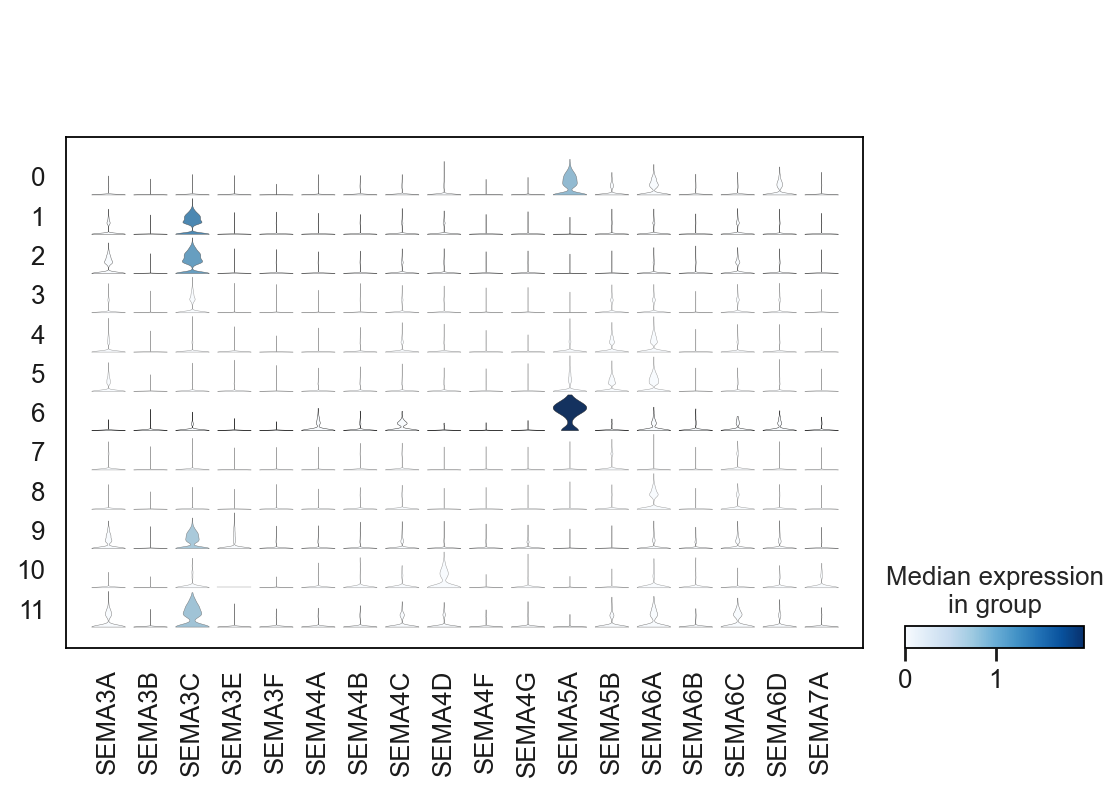

In [35]:
### Stacked Violins 플롯 그리기
sc.settings.set_figure_params(figsize=[10, 8])
sc.pl.StackedViolin(
    adata,
    semaforins, # semaforins 데이터 불러오기
    groupby='Leiden_Sel'
    ).show()

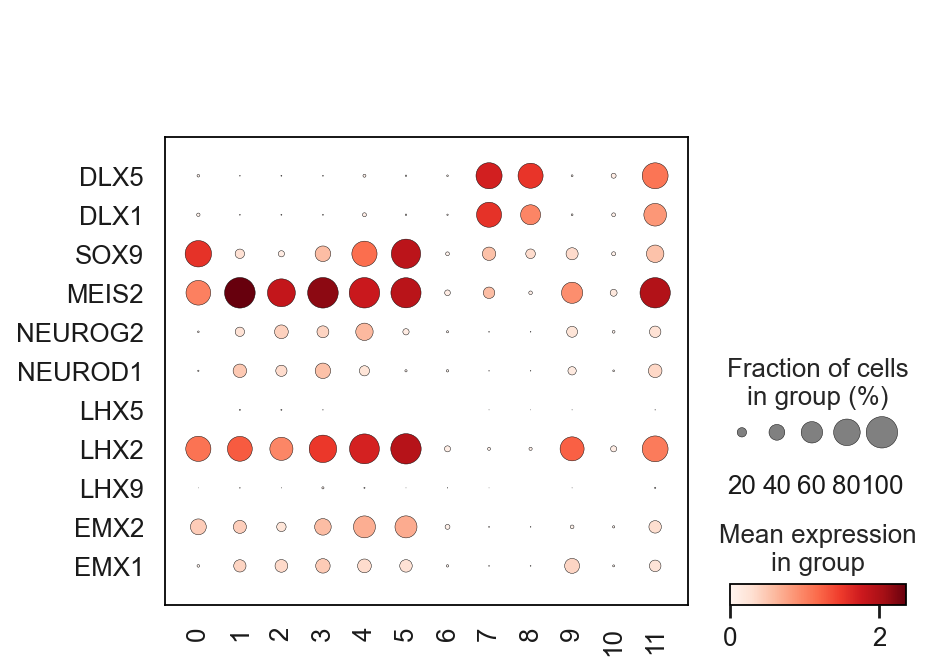

In [36]:
### dotplot 그리기
sc.pl.dotplot(
    adata,
    TFs, # TFs 데이터 불러오기
    groupby='Leiden_Sel',
    swap_axes=True)

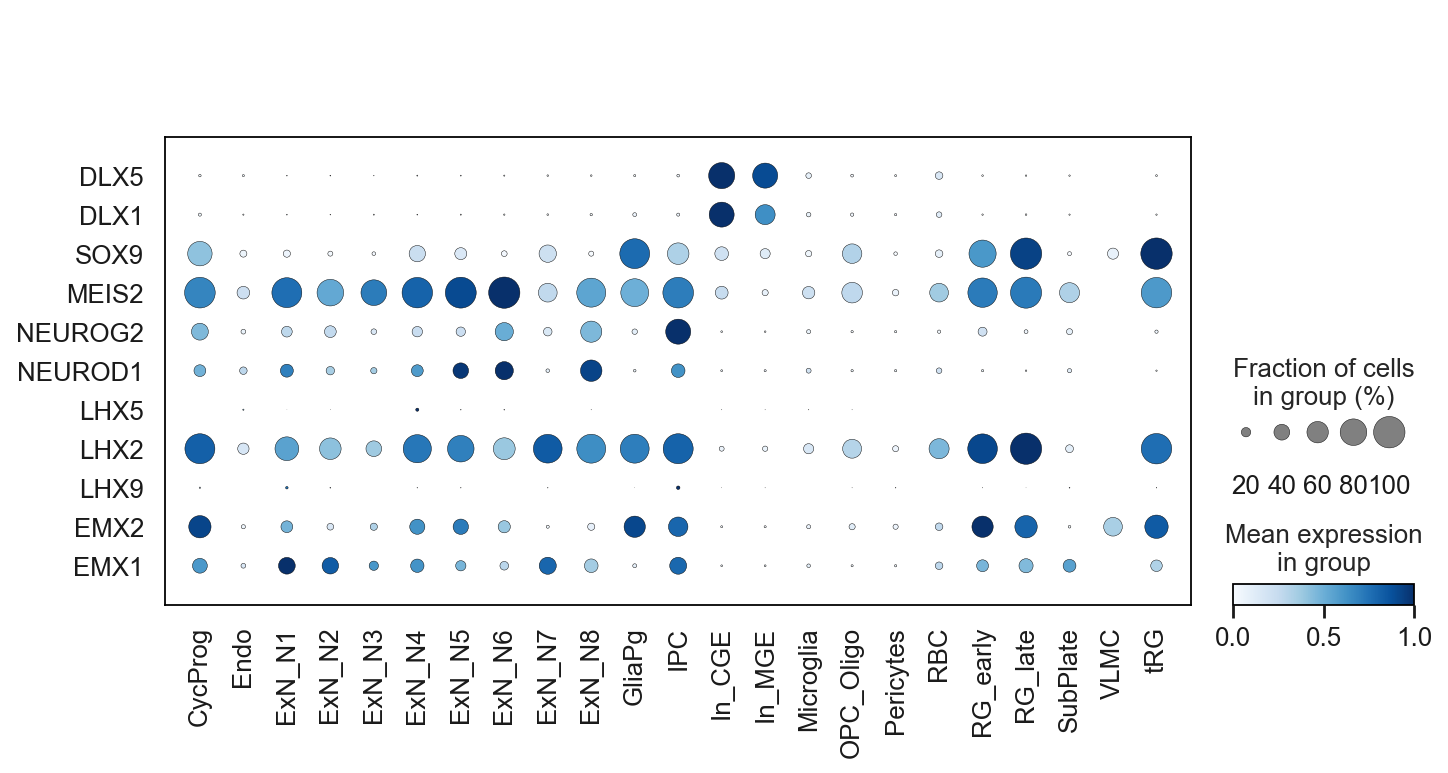

In [ ]:
### dotplot 그리기
sc.pl.dotplot(
    adata,
    TFs, # 동일하게 TFs 데이터 불러오기
    groupby='cell_label', # 이번에는 세포들을 adata.obs['cell_label'] 기준으로 그룹화한다
    standard_scale="var", # 데이터를 정규화
    cmap='Blues', # 팔레트
    swap_axes=True # X-Y 축 변경
    )

In [ ]:
### matrixplotn 그리기
sc.pl.matrixplot(
    adata,
    TFs,
    groupby='Leiden_Sel',
    swap_axes=True,
    standard_scale="var"
    )

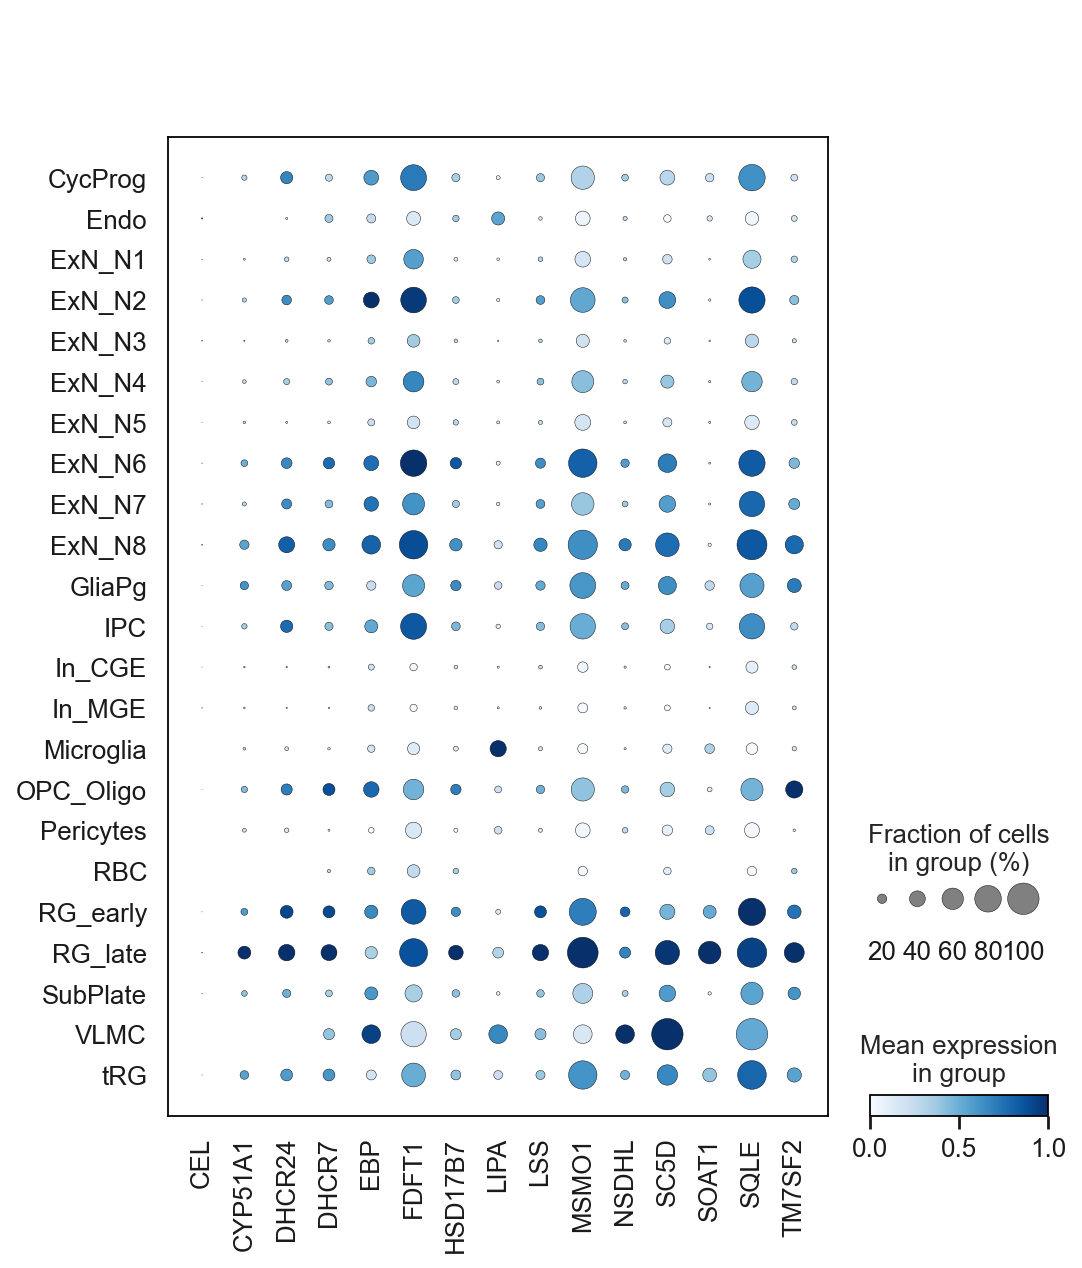

In [ ]:
### _Try yourself_: plot genes involved in steroid synthesis stratified by clusters or cell labels
### adata.obs['cell_label']에서 나타나는 steriod 데이터를 dotplot을 그려보자
sc.pl.dotplot(
    adata,
    steroid, 
    groupby='cell_label',
    standard_scale='var',
    cmap='Blues',
    )

## 7.3 Calculate and visualize gene scores
* `tl.score.genes`를 사용하여 평균발현스코어를 계산하면 동일한 세포군집에서 지속적으로 발현할 것으로 예상되는 유전자조합(gene signature)을 찾을 수 있다

computing score 'steroid_score'
    finished: added
    'steroid_score', score of gene set (adata.obs).
    549 total control genes are used. (0:00:01)


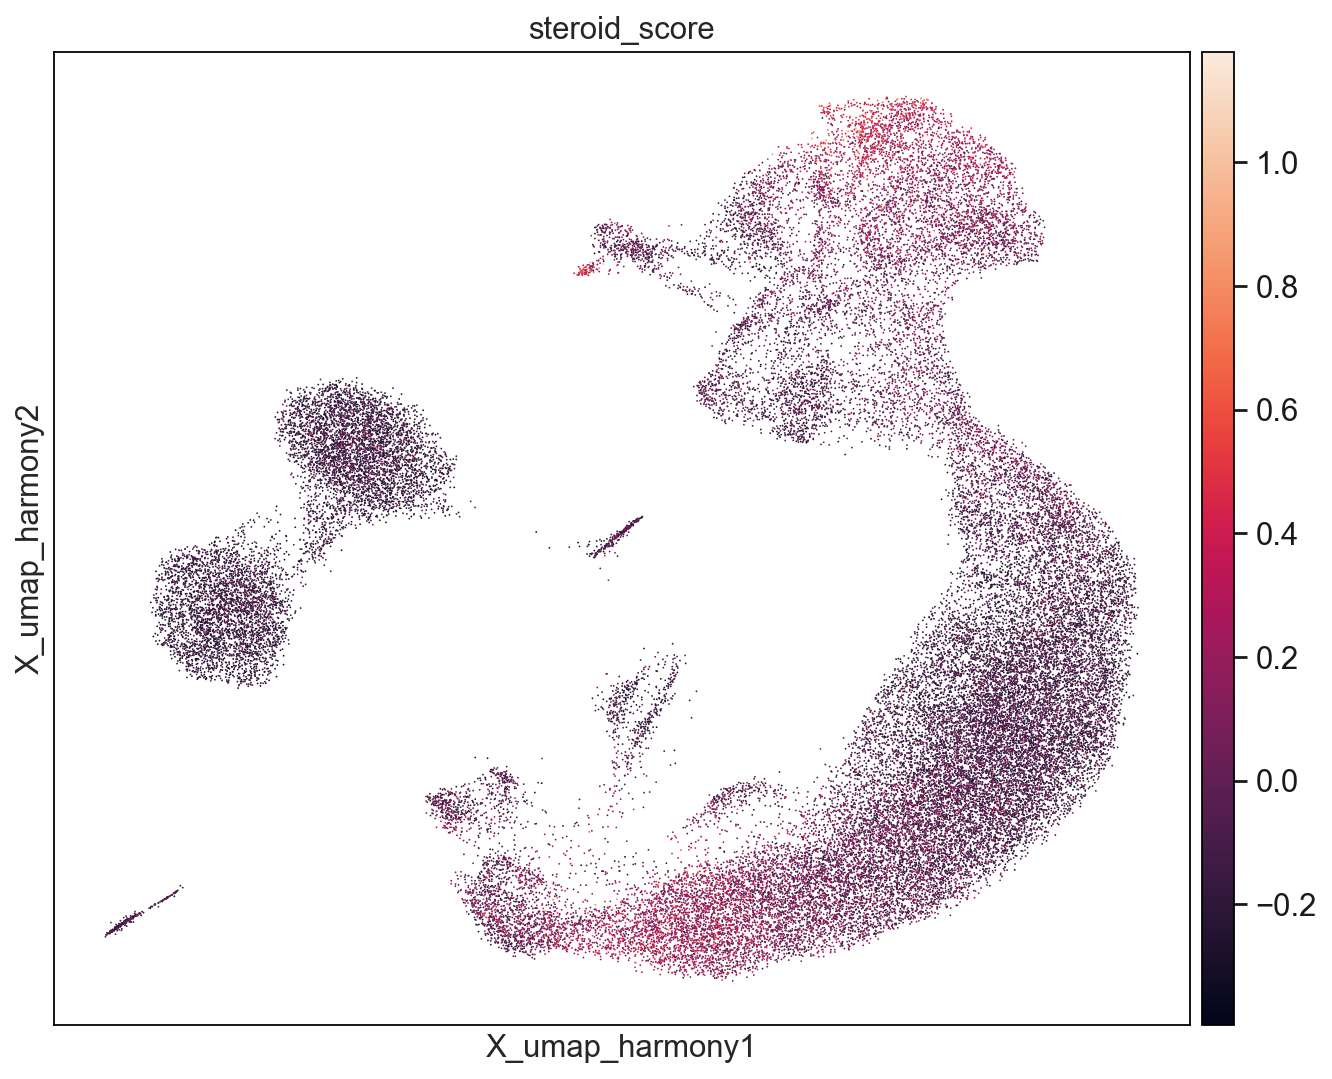

In [ ]:
### 평균발현스코어는 비슷한 발현 수준을 가진 유전자 리스트와 비교하여 점수를 산출하여, 발현량 분포의 편향을 보정한다
sc.tl.score_genes(
    adata,
    steroid,
    score_name='steroid_score'
    )

sc.pl.embedding(
    adata,
    basis="X_umap_harmony",
    color='steroid_score'
    )